***PART 1 - LOADING LIBRARIES AND DATABASE***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None #The dataset is huge. To see all of the columns, we change max columns
pd.options.display.max_seq_items=1000
pd.options.display.max_rows=1000

In [2]:
pd.options.display.max_columns = None #The dataset is huge. To see all of the columns, we change max columns
pd.options.display.max_seq_items=1000
pd.options.display.max_rows=1000

In [3]:
db_v2 ='https://drive.google.com/file/d/1XoqPujIOGHQStuAqM6Gzyqbkha4c5Y96/view?usp=sharing'
db_v3 ='https://drive.google.com/file/d/1W1V3_hl7yqbWyXF8w7mZSDTxCOx3GMzf/view?usp=sharing'
db_v4 ='https://drive.google.com/file/d/19ERs5bmAdxEfgUmTxgfIBhUoT6xPHzZy/view?usp=sharing'
db_v5 = 'https://drive.google.com/file/d/1X4YJP5fjfyk8f_TjSGBdIsTdv8MCCgY7/view?usp=sharing'
fname1 = db_v5
fname1='https://drive.google.com/uc?id=' + fname1.split('/')[-2]
dataset = pd.read_csv(fname1, low_memory=False)

In [5]:
# dataset["Proposed Use"].value_counts()
# We only keep 1 family dwelling, 2 family dwelling and appartments because it's represent 90% of the dataset and this improve prediction
idx = np.where((dataset["Proposed Use"]=="1 family dwelling") | (dataset["Proposed Use"]=="2 family dwelling") | (dataset["Proposed Use"]=="apartments"))
dataset = dataset.loc[idx]

In [4]:
dataset.shape

(7561, 42)

#DATA VISUALISATION

***Let's explore our dataset***

In [5]:
import seaborn as sns

<AxesSubplot:xlabel='Year', ylabel='Density'>

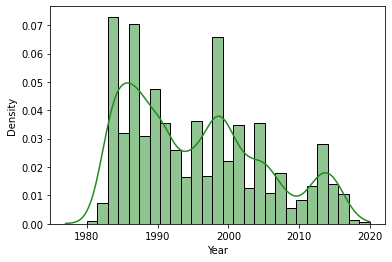

In [6]:
sns.histplot(data= dataset , x='Year',kde=True,stat='density',color='forestgreen')

<AxesSubplot:xlabel='Est_Cost_Infl', ylabel='Density'>

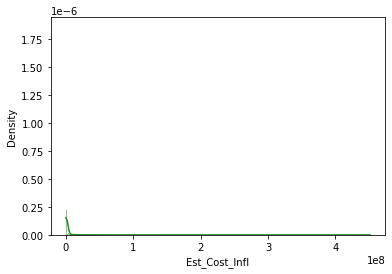

In [7]:
#histogram
sns.histplot(data= dataset , x='Est_Cost_Infl',kde=True,stat='density',color='forestgreen')

<AxesSubplot:xlabel='Est_Cost_Infl_log10', ylabel='Density'>

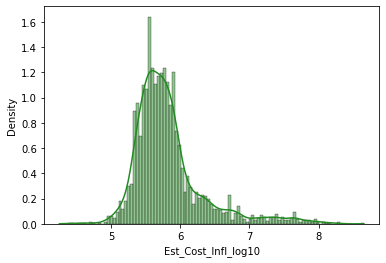

In [8]:
#histogram
sns.histplot(data= dataset , x='Est_Cost_Infl_log10',kde=True,stat='density',color='forestgreen')

<AxesSubplot:xlabel='Duration_construction_days', ylabel='Density'>

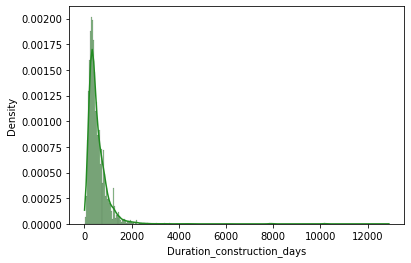

In [9]:
sns.histplot(data= dataset , x='Duration_construction_days',kde=True,stat='density',color='forestgreen')

#MACHINE LEARNING



In [11]:
! pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 10.8 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
#kaggle ref. https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard


#libraries 

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler,OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error,mean_squared_error,mean_squared_log_error,mean_absolute_error,explained_variance_score
import xgboost as xgb
import lightgbm as lgb

In [14]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = [
    "Permit Type",
    "Number of Proposed Stories",
    "Proposed Use",
    "Proposed Units",
    #"Plansets", 
    "Proposed Construction Type", 
    #"Neighborhoods - Analysis Boundaries", 
    #"Zipcode",
    'lat_lon',
    "Year",
    "Duration_construction_days"
]

target_variable = "Est_Cost_Infl_log10" #"Estimated Cost"

X = dataset.loc[:,features_list]
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())


Separating labels from features...


KeyError: "['Proposed UnitsProposed Construction Type'] not in index"

In [13]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['Permit Type', 'Number of Proposed Stories', 'Proposed Construction Type', 'Year', 'Duration_construction_days']
Found categorical features  ['Proposed Use', 'Neighborhoods - Analysis Boundaries']


In [14]:
#Manually selecting type of features
numeric_features=['Number of Proposed Stories', 'Duration_construction_days','Year']
categorical_features=['Permit Type', 'Proposed Construction Type', 'Neighborhoods - Analysis Boundaries', 'Proposed Use'] 

In [15]:
#Since we use Kfold, we don't divide data into train and test data set!
#for X_train and Y_train we use all dataset since we use K-fold
X_train = X
Y_train = Y 
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.0, random_state=0)#,stratify=Y)
print("...Done.")
print()

...Done.



In [16]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

In [17]:
# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [18]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [19]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
#print(X.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

"""
# Preprocessings on test set 
# IT IS COMMENTED SINCE WE USE K FOLD 
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
"""

Performing preprocessings on train set...
...Done.
    Permit Type  Number of Proposed Stories       Proposed Use  \
0             2                         4.0         apartments   
1             2                         3.0         apartments   
2             2                         2.0  1 family dwelling   
11            2                         4.0         apartments   
21            2                         3.0         apartments   

    Proposed Construction Type Neighborhoods - Analysis Boundaries  Year  \
0                            5                 Castro/Upper Market  1991   
1                            5                        Inner Sunset  1987   
2                            5                  West of Twin Peaks  1990   
11                          99                        Russian Hill  1977   
21                           5                      Inner Richmond  1979   

    Duration_construction_days  
0                        294.0  
1                        261.

'\n# Preprocessings on test set \n# IT IS COMMENTED SINCE WE USE K FOLD \nprint("Performing preprocessings on test set...")\nprint(X_test.head()) \nX_test = preprocessor.transform(X_test) # Don\'t fit again !! The test set is used for validating decisions\n# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.\n# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.\nprint(\'...Done.\')\nprint(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore\nprint()\n'

In [20]:
#np.isnan(Y_train).sum()

#***---CROSS VALIDATION---***


We take the cross_val_score function of Sklearn. Then, we use the function Kfold where shuffle = True to allow a shuffle attribution as cross_val_score does not have this option.

***Define Metrics***





*** Extrait of python-sklearn manuel***

ref. https://scikit-learn.org/stable/modules/model_evaluation.html


***R² score, the coefficient of determination***

The r2_score function computes the coefficient of determination, usually denoted as

.

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

As such variance is dataset dependent,
may not be meaningfully comparable across different datasets. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected (average) value of y, disregarding the input features, would get an score of 0.0.

***Mean squared error***

The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.


**Mean squared logarithmic error**

The mean_squared_log_error function computes a risk metric corresponding to the expected value of the squared logarithmic (quadratic) error or loss.

This metric is best to use when targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc. Note that this metric penalizes an under-predicted estimate greater than an over-predicted estimate.

**Mean absolute percentage error***

The mean_absolute_percentage_error (MAPE), also known as mean absolute percentage deviation (MAPD), is an evaluation metric for regression problems. The idea of this metric is to be sensitive to relative errors. It is for example not changed by a global scaling of the target variable.


***Explained variance score***

The best possible score is 1.0, lower values are worse.

Link to R² score, the coefficient of determination: https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score

The difference between the explained variance score and the R² score, the coefficient of determination is that when the explained variance score does not account for systematic offset in the prediction. For this reason, the R² score, the coefficient of determination should be preferred in general.

In the particular case where the true target is constant, the Explained Variance score is not finite: it is either NaN (perfect predictions) or -Inf (imperfect predictions). Such non-finite scores may prevent correct model optimization such as grid-search cross-validation to be performed correctly. For this reason the default behaviour of explained_variance_score is to replace them with 1.0 (perfect predictions) or 0.0 (imperfect predictions). You can set the force_finite parameter to False to prevent this fix from happening and fallback on the original Explained Variance score.



In [21]:
#Validation function
n_folds = 4
random_state = 0

In [22]:
#R2

def R2_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=random_state).get_n_splits(X_train)
    R2= cross_val_score(model, X_train, Y_train, scoring="r2", cv = kf)
    return(R2)

In [23]:
#sqrt of negative mean squared error
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=random_state).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [24]:
#sqrt of negative mean squred log error
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=random_state).get_n_splits(X_train)
    rmsle= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_log_error", cv = kf))
    return(rmsle)

In [25]:
#Mean absolute percentage error*
def mape_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=random_state).get_n_splits(X_train)
    mape= -cross_val_score(model, X_train, Y_train, scoring="neg_mean_absolute_percentage_error", cv = kf)
    return(mape)

In [26]:
#explained_variance_score 
def evs_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=random_state).get_n_splits(X_train)
    evs= cross_val_score(model, X_train, Y_train, scoring="explained_variance", cv = kf)
    return(evs)


***Definiton of base models***

***Linear Regression :***
    

Not that we dont apply Robustscaler()! It can be useful to make data more robust on outliers in the future. We can use sklearn's Robustscaler() method on pipeline


In [27]:
regressor0= LinearRegression()

***LASSO Regression :***
    



In [28]:
lasso = Lasso(alpha =0.0005, random_state=random_state)
#make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

***Elastic Net Regression :***




In [29]:
ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=random_state)
#make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

Kernel Ridge Regression :

In [30]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

***Gradient Boosting Regression :***


With huber loss, our model is more robust to outliers


In [31]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =random_state)

***XGBoost :***

In [32]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =random_state, nthread = -1)

**LightGBM - Gradient Boosting With LightGBM**

LightGBM is an algorithm developed by Microsoft in 2017. It has an advantage of changing the training algorithm that make the run time faster and likely result in a more effective model.

Ref. to the LightGBM algorithm paper:

    LightGBM: A Highly Efficient Gradient Boosting Decision Tree, 2017.
link : https://papers.nips.cc/paper/2017/hash/6449f44a102fde848669bdd9eb6b76fa-Abstract.html

In [33]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

***RandomForestRegressor :***    

In [34]:
randomForestRegressor = RandomForestRegressor(max_depth=2, random_state=0)


#Base models scores

Let's see how these base models perform on the data by evaluating the cross-validation metrics


In [35]:
description_ML = "Hello world!"#add why you do this experiment
models = [regressor0,
          ENet,
          KRR,
         # GBoost, #there is an error. need to fix later. 
          model_xgb,
          model_lgb,
          randomForestRegressor
          ]

model_names = ["\nLinear regressor model\n",
               "\nLasso model\n",
               "\nElastic Net regressor model\n",
               "\nKernel Ridge model\n",
               #"\nGradient Boosting model\n",
               "\nXGBoost model\n",
               "\nLGBM model\n",
               "\nRand Forest Regressor"
               ]


In [36]:
count = 0
for model in models :
  print(model_names[count])
  score_1 = R2_cv(model)
  print("R2 score - mean : {:.4f}  |  std : {:.4f}\n".format(score_1.mean(), score_1.std()))

  score_2 = rmse_cv(model)
  print("\nRoot mean squared error - mean : {:.4f}  |  std : {:.4f}\n".format(score_2.mean(), score_2.std()))

  score_3 = rmsle_cv(model)
  print("\nRMSLE -logarithmic error - mean : {:.4f}  |  std : {:.4f}\n".format(score_3.mean(), score_3.std()))

  score_4 = mape_cv(model)
  print("\nMean absolute percentage error - mean : {:.2f}  |  std : {:.2f}\n".format(score_4.mean(), score_4.std()))

  score_5 = evs_cv(model)
  print("\nExplained variance score - mean : {:.4f}  |  std : {:.4f}\n".format(score_5.mean(), score_5.std()))
  print("----------------END--------------------")
  count = count + 1
execfile('../src/score_ML.py')



Linear regressor model


Root mean squared error - mean : 0.5990  |  std : 0.2882


RMSLE -logarithmic error - mean : 0.1508  |  std : 0.1097


Mean absolute percentage error - mean : 0.82  |  std : 1.26


Explained variance score - mean : 0.2957  |  std : 0.0932

----------------END--------------------

Lasso model


Root mean squared error - mean : 0.5879  |  std : 0.2952


RMSLE -logarithmic error - mean : 0.1495  |  std : 0.1108


Mean absolute percentage error - mean : 0.83  |  std : 1.26


Explained variance score - mean : 0.3300  |  std : 0.0956

----------------END--------------------

Elastic Net regressor model


Root mean squared error - mean : 0.6104  |  std : 0.2903


RMSLE -logarithmic error - mean : nan  |  std : nan


Mean absolute percentage error - mean : 0.85  |  std : 1.31


Explained variance score - mean : 0.2384  |  std : 0.0724

----------------END--------------------

Kernel Ridge model

[11:03:10] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } migh

NameError: name 'score_1' is not defined

Stopped here 11/08/22

***Add your observations and conclusions here***



*** SUMMARY ***

Metric 1 :

Metric 2 :




*** Conclusion : ***



Comment on your results

Which metric to use ?
